In [39]:
from qibo.models import Circuit
from qibo.gates import X, M, H, RX
import qibo
qibo.set_backend('qibojit','numba')
qibo.set_threads(1)

[Qibo 0.1.12.dev0|INFO|2023-03-18 19:26:30]: Using qibojit (numba) backend on /CPU:0


In [110]:
c = Circuit(1)
c.add(RX(0,0.9))
c.add(M(0))
result = c(nshots=10000)

In [111]:
from qibo.symbols import Z
from qibo.hamiltonians import SymbolicHamiltonian
import numpy as np

from collections import Counter
samples = result.samples(binary=True)
#freqs = result.frequencies(binary=True)
obs = SymbolicHamiltonian(Z(0))
#exp1 = obs.expectation_from_samples(freqs)
exp = []
for j in samples:
    freq = Counter()
    freq[str(j[0])] = 1
    exp.append(obs.expectation_from_samples(freq))
var = np.var(exp)
exp = np.mean(exp)




In [112]:
def expectation_from_samples(obs, result):
    from collections import Counter
    samples = result.samples()
    exp = []
    for j in samples:
        freq = Counter()
        freq[str(j[0])] = 1
        exp.append(obs.expectation_from_samples(freq))
    var = np.var(exp)
    exp = np.mean(exp)
    return exp, var




In [113]:
exp, var = expectation_from_samples(obs, result)

In [114]:
exp

0.627

In [115]:
var

0.606871

In [108]:
(1 - obs.expectation(result.state())**2)

0.6136010473465436

In [116]:
1 - exp**2    

0.6068709999999999

In [17]:
exp2

[-1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0]

In [117]:
import pennylane as qml
from pennylane import numpy as np

# set the random seed
np.random.seed(4)

coeffs = [2, 4, -1, 5, 2]

obs = [
  qml.PauliX(1),
  qml.PauliZ(1),
  qml.PauliX(0) @ qml.PauliX(1),
  qml.PauliY(0) @ qml.PauliY(1),
  qml.PauliZ(0) @ qml.PauliZ(1)
]

In [118]:
num_layers = 2
num_wires = 2

# create a device that estimates expectation values using a finite number of shots
non_analytic_dev = qml.device("default.qubit", wires=num_wires, shots=100)

# create a device that calculates exact expectation values
analytic_dev = qml.device("default.qubit", wires=num_wires, shots=None)

In [124]:
total_shots = 8000
prob_shots = np.abs(coeffs) / np.sum(np.abs(coeffs))
print(prob_shots)

[0.14285714 0.28571429 0.07142857 0.35714286 0.14285714]


In [128]:
from scipy.stats import multinomial

si = multinomial(n=total_shots, p=prob_shots)
samples = si.rvs()[0]
print(samples)
print(sum(samples))

[1161 2311  543 2826 1159]
8000


In [129]:
from pennylane.templates.layers import StronglyEntanglingLayers


@qml.qnode(non_analytic_dev, diff_method="parameter-shift", interface="autograd")
def qnode(weights, observable):
    StronglyEntanglingLayers(weights, wires=non_analytic_dev.wires)
    return qml.expval(observable)

def cost(params):
    # sample from the multinomial distribution
    shots_per_term = si.rvs()[0]

    result = 0

    for o, c, s in zip(obs, coeffs, shots_per_term):
        # evaluate the QNode corresponding to
        # the Hamiltonian term, and add it on to our running sum
        result += c * qnode(params, o, shots=int(s))

    return result

In [130]:
param_shape = StronglyEntanglingLayers.shape(n_layers=num_layers, n_wires=num_wires)
init_params = np.random.uniform(low=0.0, high=2*np.pi, size=param_shape, requires_grad=True)
print(cost(init_params))

-2.6312984859281285


In [131]:
opt = qml.AdamOptimizer(0.05)
params = init_params

cost_wrs = []
shots_wrs = []

for i in range(100):
    params, _cost = opt.step_and_cost(cost, params)
    cost_wrs.append(_cost)
    shots_wrs.append(total_shots*i)
    print("Step {}: cost = {} shots used = {}".format(i, cost_wrs[-1], shots_wrs[-1]))

Step 0: cost = -2.4663956672104046 shots used = 0
Step 1: cost = -3.809171614198501 shots used = 8000
Step 2: cost = -4.614013599261993 shots used = 16000
Step 3: cost = -5.591415069121189 shots used = 24000
Step 4: cost = -5.962940370368805 shots used = 32000
Step 5: cost = -6.224401987593091 shots used = 40000
Step 6: cost = -6.618860378264609 shots used = 48000
Step 7: cost = -7.042354816153301 shots used = 56000
Step 8: cost = -7.319676727768921 shots used = 64000
Step 9: cost = -7.249763537383103 shots used = 72000
Step 10: cost = -7.245174936964957 shots used = 80000
Step 11: cost = -7.540979408681092 shots used = 88000
Step 12: cost = -7.549433852843505 shots used = 96000
Step 13: cost = -7.522252907921979 shots used = 104000
Step 14: cost = -7.7492407699515775 shots used = 112000
Step 15: cost = -7.604951243704169 shots used = 120000
Step 16: cost = -7.664632491977047 shots used = 128000
Step 17: cost = -7.669394834252008 shots used = 136000
Step 18: cost = -7.728680893353483 s

In [132]:
@qml.qnode(non_analytic_dev, diff_method="parameter-shift", interface="autograd")
def qnode(weights, obs):
    StronglyEntanglingLayers(weights, wires=non_analytic_dev.wires)
    return qml.expval(obs)

def cost(params):
    shots_per_term = int(total_shots / len(coeffs))

    result = 0

    for o, c in zip(obs, coeffs):

        # evaluate the QNode corresponding to
        # the Hamiltonian term, and add it on to our running sum
        result += c * qnode(params, o, shots=shots_per_term)

    return result

opt = qml.AdamOptimizer(0.05)
params = init_params

cost_adam = []
shots_adam = []

for i in range(100):
    params, _cost = opt.step_and_cost(cost, params)
    cost_adam.append(_cost)
    shots_adam.append(total_shots*i)
    print("Step {}: cost = {} shots used = {}".format(i, cost_adam[-1], shots_adam[-1]))

Step 0: cost = -2.7775 shots used = 0
Step 1: cost = -3.8724999999999996 shots used = 8000
Step 2: cost = -4.442500000000001 shots used = 16000
Step 3: cost = -5.2475000000000005 shots used = 24000
Step 4: cost = -5.884999999999999 shots used = 32000
Step 5: cost = -6.3575 shots used = 40000
Step 6: cost = -6.765000000000001 shots used = 48000
Step 7: cost = -6.953749999999999 shots used = 56000
Step 8: cost = -7.284999999999999 shots used = 64000
Step 9: cost = -7.20125 shots used = 72000
Step 10: cost = -7.52125 shots used = 80000
Step 11: cost = -7.5725 shots used = 88000
Step 12: cost = -7.54875 shots used = 96000
Step 13: cost = -7.60375 shots used = 104000
Step 14: cost = -7.58875 shots used = 112000
Step 15: cost = -7.784999999999999 shots used = 120000
Step 16: cost = -7.925 shots used = 128000
Step 17: cost = -7.348750000000001 shots used = 136000
Step 18: cost = -7.48625 shots used = 144000
Step 19: cost = -7.5875 shots used = 152000
Step 20: cost = -7.4325 shots used = 16000

/tmp/ipykernel_1730844/4262935572.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


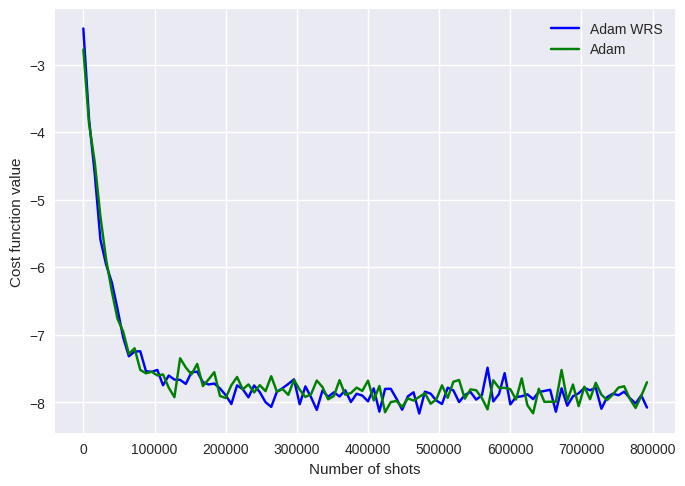

In [133]:
from matplotlib import pyplot as plt

plt.style.use("seaborn")
plt.plot(shots_wrs, cost_wrs, "b", label="Adam WRS")
plt.plot(shots_adam, cost_adam, "g", label="Adam")

plt.ylabel("Cost function value")
plt.xlabel("Number of shots")
plt.legend()
plt.show()

In [144]:
class Rosalin:

    def __init__(self, obs, coeffs, min_shots, mu=0.99, b=1e-6, lr=0.07):
        self.obs = obs
        self.coeffs = coeffs

        self.lipschitz = np.sum(np.abs(coeffs))

        if lr > 2 / self.lipschitz:
            raise ValueError("The learning rate must be less than ", 2 / self.lipschitz)

        # hyperparameters
        self.min_shots = min_shots
        self.mu = mu  # running average constant
        self.b = b    # regularization bias
        self.lr = lr  # learning rate

        # keep track of the total number of shots used
        self.shots_used = 0
        # total number of iterations
        self.k = 0
        # Number of shots per parameter
        self.s = np.zeros_like(params, dtype=np.float64) + min_shots

        # Running average of the parameter gradients
        self.chi = None
        # Running average of the variance of the parameter gradients
        self.xi = None

    def estimate_hamiltonian(self, params, shots):
        """Returns an array containing length ``shots`` single-shot estimates
        of the Hamiltonian. The shots are distributed randomly over
        the terms in the Hamiltonian, as per a Multinomial distribution.

        Since we are performing single-shot estimates, the QNodes must be
        set to 'sample' mode.
        """
        rosalin_device = qml.device("default.qubit", wires=num_wires, shots=100)

        # determine the shot probability per term
        prob_shots = np.abs(coeffs) / np.sum(np.abs(coeffs))

        # construct the multinomial distribution, and sample
        # from it to determine how many shots to apply per term
        si = multinomial(n=shots, p=prob_shots)
        shots_per_term = si.rvs()[0]

        results = []

        @qml.qnode(rosalin_device, diff_method="parameter-shift", interface="autograd")
        def qnode(weights, observable):
            StronglyEntanglingLayers(weights, wires=rosalin_device.wires)
            return qml.sample(observable)

        for o, c, p, s in zip(self.obs, self.coeffs, prob_shots, shots_per_term):

            # if the number of shots is 0, do nothing
            if s == 0:
                continue

            # evaluate the QNode corresponding to
            # the Hamiltonian term
            res = qnode(params, o, shots=int(s))

            if s == 1:
                res = np.array([res])

            # Note that, unlike above, we divide each term by the
            # probability per shot. This is because we are sampling one at a time.
            results.append(c * res / p)

        return np.concatenate(results)

    def evaluate_grad_var(self, i, params, shots):
        """Evaluate the gradient, as well as the variance in the gradient,
        for the ith parameter in params, using the parameter-shift rule.
        """
        shift = np.zeros_like(params)
        shift[i] = np.pi / 2

        shift_forward = self.estimate_hamiltonian(params + shift, shots)
        shift_backward = self.estimate_hamiltonian(params - shift, shots)

        g = np.mean(shift_forward - shift_backward) / 2
        s = np.var((shift_forward - shift_backward) / 2, ddof=1)
        print(s)
        print(np.var(shift_forward - shift_backward, ddof=1)/4)

        return g, s

    def step(self, params):
        """Perform a single step of the Rosalin optimizer."""
        # keep track of the number of shots run
        self.shots_used += int(2 * np.sum(self.s))

        # compute the gradient, as well as the variance in the gradient,
        # using the number of shots determined by the array s.
        grad = []
        S = []

        p_ind = list(np.ndindex(*params.shape))

        for l in p_ind:
            # loop through each parameter, performing
            # the parameter-shift rule
            g_, s_ = self.evaluate_grad_var(l, params, self.s[l])
            grad.append(g_)
            S.append(s_)

        grad = np.reshape(np.stack(grad), params.shape)
        S = np.reshape(np.stack(S), params.shape)

        # gradient descent update
        params = params - self.lr * grad

        if self.xi is None:
            self.chi = np.zeros_like(params, dtype=np.float64)
            self.xi = np.zeros_like(params, dtype=np.float64)

        # running average of the gradient variance
        self.xi = self.mu * self.xi + (1 - self.mu) * S
        xi = self.xi / (1 - self.mu ** (self.k + 1))

        # running average of the gradient
        self.chi = self.mu * self.chi + (1 - self.mu) * grad
        chi = self.chi / (1 - self.mu ** (self.k + 1))

        # determine the new optimum shots distribution for the next
        # iteration of the optimizer
        s = np.ceil(
            (2 * self.lipschitz * self.lr * xi)
            / ((2 - self.lipschitz * self.lr) * (chi ** 2 + self.b * (self.mu ** self.k)))
        )

        # apply an upper and lower bound on the new shot distributions,
        # to avoid the number of shots reducing below min(2, min_shots),
        # or growing too significantly.
        gamma = (
            (self.lr - self.lipschitz * self.lr ** 2 / 2) * chi ** 2
            - xi * self.lipschitz * self.lr ** 2 / (2 * s)
        ) / s

        argmax_gamma = np.unravel_index(np.argmax(gamma), gamma.shape)
        smax = s[argmax_gamma]
        self.s = np.clip(s, min(2, self.min_shots), smax)

        self.k += 1
        return params


In [145]:
@qml.qnode(analytic_dev, interface="autograd")
def cost_analytic(weights):
    StronglyEntanglingLayers(weights, wires=analytic_dev.wires)
    return qml.expval(qml.Hamiltonian(coeffs, obs))

In [146]:
opt = Rosalin(obs, coeffs, min_shots=10)
params = init_params

cost_rosalin = [cost_analytic(params)]
shots_rosalin = [0]

for i in range(60):
    params = opt.step(params)
    cost_rosalin.append(cost_analytic(params))
    shots_rosalin.append(opt.shots_used)
    print(f"Step {i}: cost = {cost_rosalin[-1]}, shots_used = {shots_rosalin[-1]}")

165.5111111111111
165.5111111111111
95.82222222222222
95.82222222222222
95.82222222222224
95.82222222222224
34.844444444444434
34.844444444444434
52.26666666666667
52.26666666666667
87.11111111111111
87.11111111111111
150.26666666666668
150.26666666666668
89.28888888888889
89.28888888888889
121.95555555555555
121.95555555555555
106.71111111111112
106.71111111111112
121.95555555555555
121.95555555555555
78.39999999999999
78.39999999999999
Step 0: cost = -6.914293170770618, shots_used = 240
65.33333333333333
65.33333333333333
65.33333333333334
65.33333333333334
65.33333333333334
65.33333333333334
196.0
196.0
196.0
196.0
196.0
196.0
65.33333333333334
65.33333333333334
196.0
196.0
0.0
0.0
196.0
196.0
65.33333333333333
65.33333333333333
65.33333333333333
65.33333333333333
Step 1: cost = -6.585365633324259, shots_used = 312
392.0
392.0
98.0
98.0
98.0
98.0
0.0
0.0
98.0
98.0
0.0
0.0
98.0
98.0
98.0
98.0
98.0
98.0
0.0
0.0
0.0
0.0
0.0
0.0
Step 2: cost = -4.937795513412956, shots_used = 360
24.5
2

KeyboardInterrupt: 

In [147]:
x=np.zeros(2)

In [148]:
x[:] = 1, 2

In [149]:
X

qibo.gates.gates.X

In [150]:
x

tensor([1., 2.], requires_grad=True)